## Machine Learning

### Importação de bibliotecas

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343676,2.362768,0.203216


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   longitude                 17564 non-null  float32 
 1   latitude                  17564 non-null  float32 
 2   housing_median_age        17564 non-null  int8    
 3   total_rooms               17564 non-null  int16   
 4   total_bedrooms            17564 non-null  int16   
 5   population                17564 non-null  int16   
 6   households                17564 non-null  int16   
 7   median_income             17564 non-null  float32 
 8   median_house_value        17564 non-null  int32   
 9   ocean_proximity           17564 non-null  category
 10  median_income_cat         17564 non-null  int64   
 11  rooms_per_household       17564 non-null  float32 
 12  population_per_household  17564 non-null  float32 
 13  bedrooms_per_room         17564 non-null  floa

### Variáveis categóricas

In [4]:
# Variáveis categóricas
coluna_target = ["median_house_value"]

coluna_one_hot_encoder = ["ocean_proximity"] # Coluna categórica que não está ordenada

coluna_ordinal_encoder = ["median_income_cat"] # Coluna categorica que já está ordenada

In [5]:
preprocessamento = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), coluna_ordinal_encoder), # Coluna categorica que já está ordenada
        ("one_hot_encoder", OneHotEncoder(), coluna_one_hot_encoder), # Coluna categórica que não está ordenada
    ],
    remainder="passthrough",
)

In [6]:
X = df.drop(columns=coluna_target)
y = df[coluna_target]

In [7]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.230003,37.880001,41,880,129,322,126,8.3252,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.220001,37.860001,21,7099,1106,2401,1138,8.3014,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.260002,37.840000,42,2555,665,1206,595,2.0804,NEAR BAY,2,4.294117,2.026891,0.260274
3,-122.260002,37.849998,50,1120,283,697,264,2.1250,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.260002,37.840000,50,2239,455,990,419,1.9911,NEAR BAY,2,5.343676,2.362768,0.203216


In [8]:
y.head()

,median_house_value
0,452600
1,358500
2,226700
3,140000
4,158700


In [9]:
target_transformer = PowerTransformer()

regressors = {
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    "LinearRegression": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    "LinearRegression_target": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": target_transformer,
    },
}

In [10]:
resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.0,0.008004,-0.000081,-77516.042766,-96239.705692,0.008004
1,DummyRegressor,0.004892,0.005111,-0.000146,-75787.787194,-95217.629397,0.010003
2,DummyRegressor,0.002817,0.003027,-0.001737,-76753.598961,-96253.253947,0.005844
3,DummyRegressor,0.0,0.005926,-0.000101,-76837.804811,-95983.885799,0.005926
4,DummyRegressor,0.0,0.0,-0.000114,-76617.245449,-96182.764729,0.0
5,LinearRegression,0.032519,0.036603,0.682162,-39855.690921,-54254.958115,0.069122
6,LinearRegression,0.040433,0.015598,0.66999,-40272.565406,-54695.230224,0.056031
7,LinearRegression,0.022859,0.008317,0.649247,-42178.059246,-56955.988686,0.031176
8,LinearRegression,0.024487,0.024637,0.669873,-40806.492452,-55146.31876,0.049124
9,LinearRegression,0.018685,0.017441,0.669023,-40788.496555,-55331.351171,0.036126


In [11]:
df_resultados.groupby("model").mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.001542,0.004414,-0.000436,-76702.495836,-95975.447913,0.005955
LinearRegression,0.027797,0.020519,0.668059,-40780.260916,-55276.769391,0.048316
LinearRegression_target,0.063365,0.012429,0.671185,-38909.258356,-55011.704377,0.075794


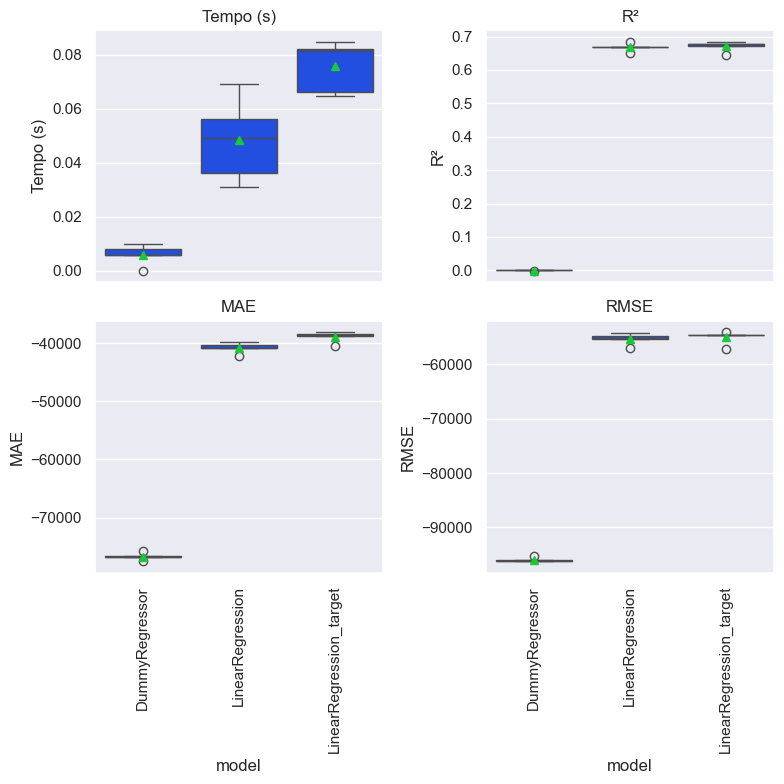

In [12]:
plot_comparar_metricas_modelos(df_resultados)

- Tempo: transformador de target do LinearRegression leva 2x mais que só o LinearRegression
- R2, MAE e RMSE: teve pequenas melhorias do LinearRegression com TargetTransformer em relação ao LinearRegression
- Usando ambos os modelos de LinearRegression é melhor que usar o DummyRegression (chutando a média)

### Avaliando a transformação de target

In [13]:
param_grid = {
    "transformer": [
        None,
        PowerTransformer(),
        QuantileTransformer(output_distribution="normal"),
    ]
}

In [14]:
grid_search = grid_search_cv_regressor(
    regressor=LinearRegression(), 
    preprocessor=preprocessamento,
    target_transformer=target_transformer,
    param_grid=param_grid
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(remainder='passthrough',
                                                                                               transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot_encoder',
                                                                                                              OneHotEncoder(),
                                                                                                              ['ocean_proximity'])])),
                                                                            ('reg',
                                                                             LinearRegression())]),
                                                  transformer=PowerTransformer()),
             n_jobs=-1,
             param_grid={'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [15]:
grid_search.fit(X, y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(remainder='passthrough',
                                                                                               transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot_encoder',
                                                                                                              OneHotEncoder(),
                                                                                                              ['ocean_proximity'])])),
                                                                            ('reg',
                                                                             LinearRegression())]),
                                                  transformer=PowerTransformer()),
             n_jobs=-1,
             param_grid={'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [16]:
grid_search.best_params_

{'transformer': QuantileTransformer(output_distribution='normal')}

QuantileTransformer apresentou melhor parâmetro de transformador que o PowerTransformer

In [17]:
grid_search.best_score_

np.float64(-54417.87027091748)

- QuantileTransformer: -54411
- PowerTransformer: -55017
- Obs: quanto mais próximo de 0, melhor

In [18]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_["reg"].coef_,
    grid_search.best_estimator_.regressor_["preprocessor"].get_feature_names_out(),
)

coefs

,coeficiente
remainder__longitude,-0.295623
remainder__latitude,-0.289131
remainder__population_per_household,-0.280467
one_hot_encoder__ocean_proximity_INLAND,-0.277218
one_hot_encoder__ocean_proximity_NEAR BAY,-0.022367
remainder__total_bedrooms,-0.000227
remainder__total_rooms,-0.000061
remainder__population,-0.000034
remainder__households,0.000856
remainder__housing_median_age,0.006584


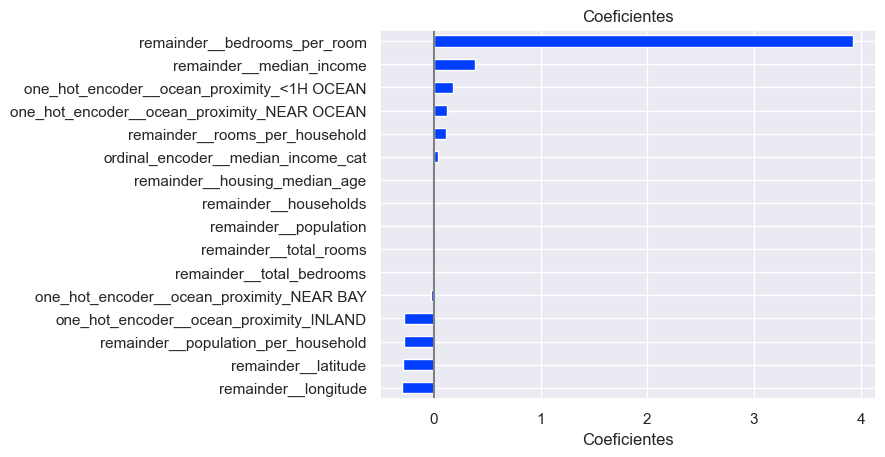

In [19]:
plot_coeficientes(coefs)

A coluna bedrooms_per_room possui mais relevância pra coluna target (median_house_value)

In [20]:
regressors = {
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    "LinearRegression": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    "LinearRegression_target_power": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": target_transformer,
    },
    "LinearRegression_target_quantile": {
        "preprocessor": grid_search.best_estimator_.regressor_["preprocessor"],
        "regressor": grid_search.best_estimator_.regressor_["reg"],
        "target_transformer": grid_search.best_estimator_.transformer_,
    },
}

In [21]:
resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.018311,0.002488,-0.000081,-77516.042766,-96239.705692,0.020799
1,DummyRegressor,0.0,0.009541,-0.000146,-75787.787194,-95217.629397,0.009541
2,DummyRegressor,0.002811,0.0,-0.001737,-76753.598961,-96253.253947,0.002811
3,DummyRegressor,0.0,0.0,-0.000101,-76837.804811,-95983.885799,0.0
4,DummyRegressor,0.0,0.013048,-0.000114,-76617.245449,-96182.764729,0.013048
5,LinearRegression,0.037769,0.010002,0.682162,-39855.690921,-54254.958115,0.047771
6,LinearRegression,0.032666,0.014578,0.66999,-40272.565406,-54695.230224,0.047245
7,LinearRegression,0.028659,0.003009,0.649247,-42178.059246,-56955.988686,0.031668
8,LinearRegression,0.026873,0.005008,0.669873,-40806.492452,-55146.31876,0.031882
9,LinearRegression,0.045755,0.013507,0.669023,-40788.496555,-55331.351171,0.059263


In [22]:
df_resultados.groupby("model").mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.004224,0.005015,-0.000436,-76702.495836,-95975.447913,0.00924
LinearRegression,0.034344,0.009221,0.668059,-40780.260916,-55276.769391,0.043565
LinearRegression_target_power,0.062058,0.023169,0.671185,-38909.258356,-55011.704377,0.085227
LinearRegression_target_quantile,0.033946,0.015742,0.678142,-38677.472988,-54426.195692,0.049688


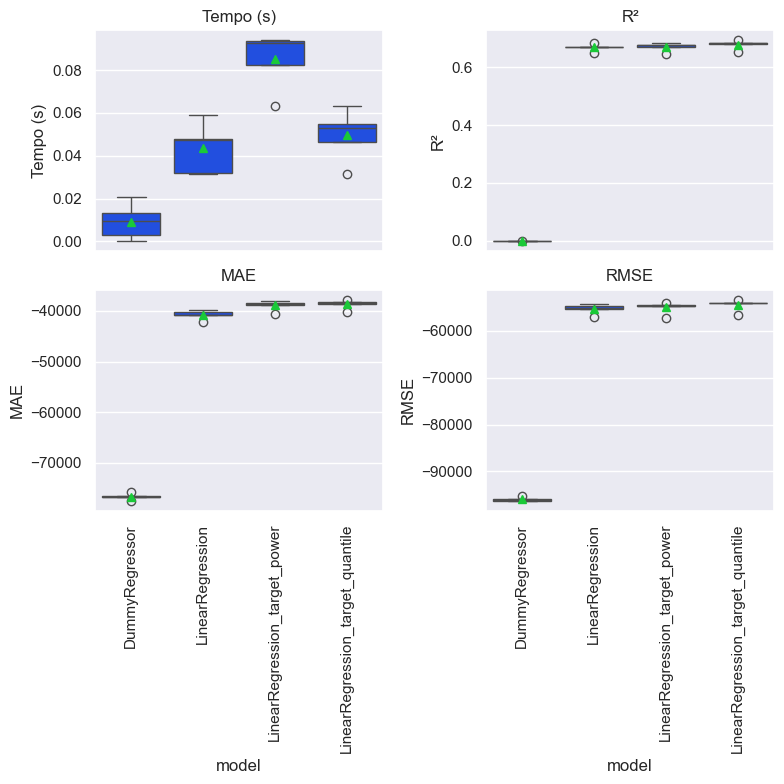

In [23]:
plot_comparar_metricas_modelos(df_resultados)

- Tempo: com a transformação de target o QuantileTransformer é mais rápida que PowerTransformer
- R2, MAE, RMSE: QuantileTransformer melhora um pouco as métricas que o PowerTransformer
- É melhor usar o transformador de target do QuantileTransformer que o PowerTransformer

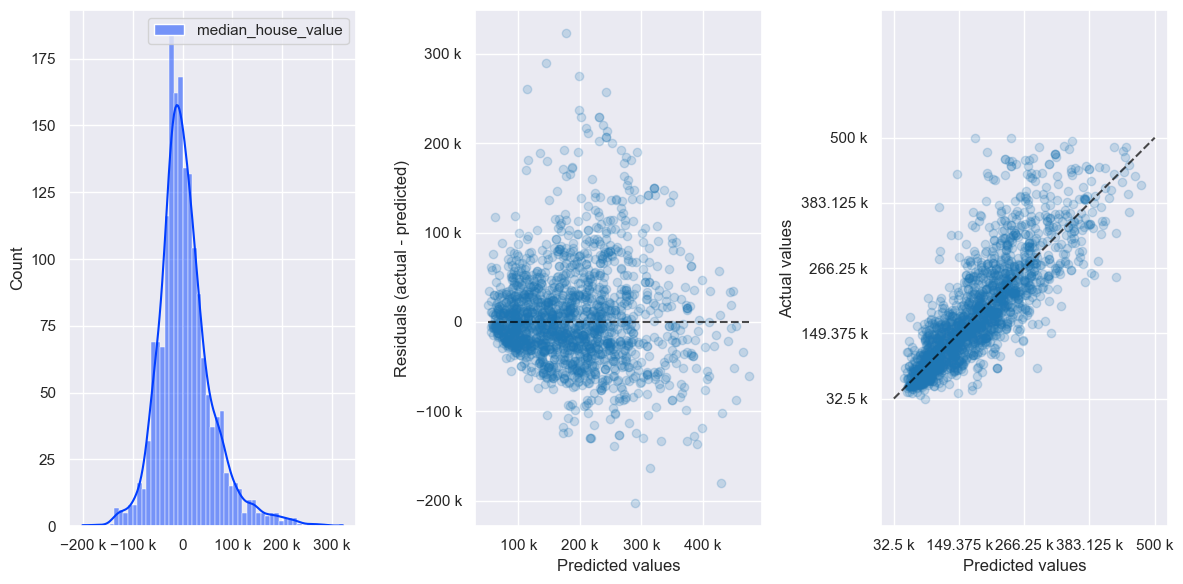

In [24]:
# Plota gráfico de resíduos com melhor modelo, usando 10% dos dados e com formatação de abreviação dos números
plot_residuos_estimador(grid_search.best_estimator_, X, y, fracao_amostra=0.1, eng_formatter=True)

Pegando 10% dos dados e comparando os dados reais com os dados do melhor estimador de modelo (QuantileTransformer):
- Percebe-se que uma parte significativa dos pontos estão próximos da reta no gráfico de resíduos (2), fazendo que o modelo tenha menos erros
- Possue mais erros positivos que negativos, sendo observado tanto pelo histograma (1) com a cauda mais alongada para os valores positivos e o gráfico de dispersão de resíduos (2) com mais valores acima da reta que abaixo da reta